In [ ]:
import sys
sys.path.append("../../src")

# Calibrate Cameras

In [173]:
import numpy as np
import cv2
from cv2 import aruco
from matplotlib import pyplot as plt

def calibrate_charuco(images: list, marker_length, square_length):
    '''Apply camera calibration using aruco.
    The dimensions are in cm.
    '''
    aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50) 
    board = aruco.CharucoBoard_create(5, 7, square_length, marker_length, aruco_dict)
    arucoParams = aruco.DetectorParameters_create()

    image_id = -1
    valid_images, image_ids, corners_list, id_list = [], [], [], []
    # Find the ArUco markers inside each image
    for image in images:
        image_id = image_id + 1

        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        corners, ids, _ = aruco.detectMarkers(
            img_gray, 
            aruco_dict, 
            parameters=arucoParams
        )

        if ids is None: # did not detect any corners
            continue

        resp, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(
            markerCorners=corners,
            markerIds=ids,
            image=img_gray,
            board=board
        )

        if charuco_corners is None:
            continue

        # print markers on image
        for corner in corners:
            corner = corner.astype(np.int32)
            cv2.polylines(image, [corner], True, (0, 0, 255), thickness=5)

        # print charuco corners on image
        for corner in charuco_corners:
            corner = corner.astype(np.int32)
            cv2.circle(image, corner[0], 15, (255, 0, 0), thickness=5)

        # If a Charuco board was found, let's collect image/corner points
        # Requiring at least 20 squares
        if resp > 20:
            # Add these corners and ids to our calibration arrays
            valid_images.append(image)
            corners_list.append(charuco_corners)
            id_list.append(charuco_ids)
            image_ids.append(image_id)

    # Actual calibration
    _, _, _, rvecs, tvecs = aruco.calibrateCameraCharuco(
        charucoCorners=corners_list, 
        charucoIds=id_list, 
        board=board, 
        imageSize=img_gray.shape, 
        cameraMatrix=None, 
        distCoeffs=None)
    
    return rvecs, tvecs, valid_images, image_ids


def save_coefficients(mtx, dist, tmat, path): 
    '''Save the camera matrix and the distortion coefficients to given path/file.''' 
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write('K', mtx)
    cv_file.write('D', dist)
    cv_file.write('T', tmat)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()

def load_coefficients(path):
    '''Loads camera matrix and distortion coefficients.'''
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode('K').mat()
    dist_matrix = cv_file.getNode('D').mat()
    transf_matrix = cv_file.getNode('T').mat()

    cv_file.release()
    return [camera_matrix, dist_matrix, transf_matrix]

In [ ]:
def get_homogeneous(rvecs, tvecs):
    hom = np.identity(4)
    rmat, _ = cv2.Rodrigues(np.reshape(rvecs, -1))
    hom[0:3, 0:3] = rmat
    hom[0:3, 3] = np.squeeze(tvecs[0])
    return hom

### Calculate & save intr. & extr. matrix

Mean of Transformation matrizes:
[[ 0.50757248 -0.5183488  -0.09532571]
 [-0.6726912   0.1711528  -0.24778792]
 [ 0.23709205  0.14555896 -0.27815046]]
Standard Deviation of Transformation matrizes:
[[3.64213492e-01 5.73202227e-01 5.81846165e-02 1.39761774e+02]
 [2.84295562e-01 5.78376019e-01 2.03596725e-01 1.07643021e+02]
 [1.42016371e-01 1.33244966e-01 8.98503980e-01 3.31125358e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]


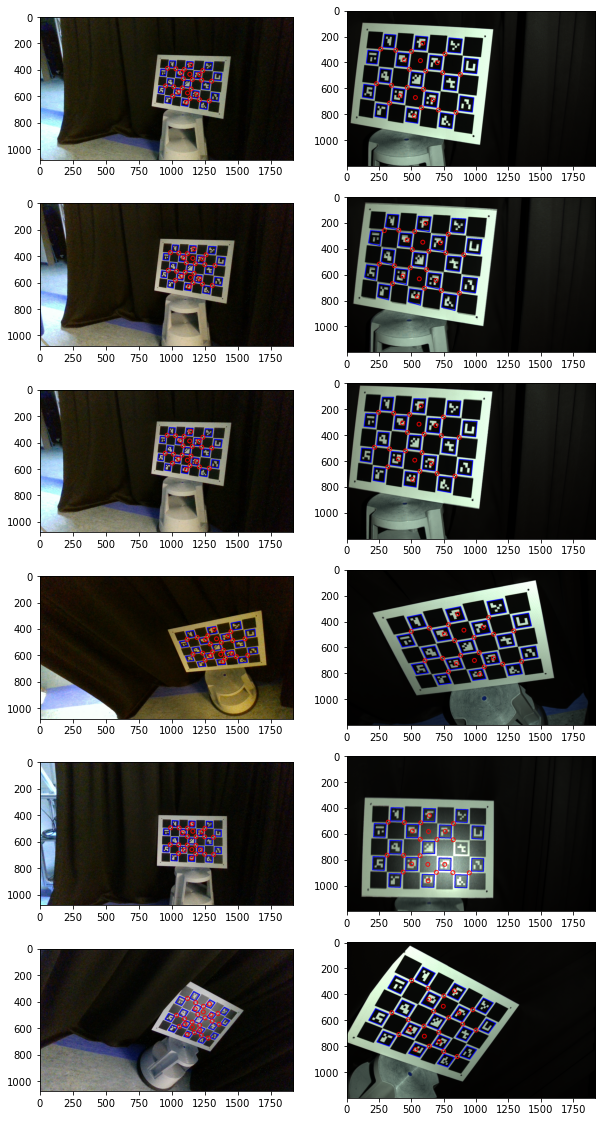

In [185]:
from matplotlib import pyplot as plt
from models.dataset.DatasetHelper import openImageDataset


# Parameters
DATASET_PATH = "../../resources/images/uncalibrated/calibration_dataset.npz"

# Dimensions in cm
MARKER_LENGTH = 5.625
SQUARE_LENGTH = 7.5

# load images
realsenseColor, _, zividColor, _ = openImageDataset(DATASET_PATH)

# Calibrate 
rvecs_rs, tvecs_rs, valid_images_rs, image_ids_rs = calibrate_charuco(
    realsenseColor,
    MARKER_LENGTH,
    SQUARE_LENGTH
)

rvecs_ziv, tvecs_ziv, valid_images_ziv, image_ids_ziv = calibrate_charuco(
    zividColor,
    MARKER_LENGTH,
    SQUARE_LENGTH
)

# Calculate both homogenous transformation matrixes
ids = [(i, j)  for i, x in enumerate(image_ids_rs) for j, y in enumerate(image_ids_ziv) if x == y]

Ts_rs = []
Ts_ziv = []

for idx, (id_rs, id_ziv) in enumerate(ids):
    Ts_rs.append(get_homogeneous(rvecs_rs[id_rs], tvecs_rs[id_rs]))
    Ts_ziv.append(get_homogeneous(rvecs_ziv[id_ziv], tvecs_ziv[id_ziv]))

Ts_ziv_to_rs = []
for T_rs, T_ziv in zip(Ts_rs, Ts_ziv):
    ex = np.linalg.inv(T_rs) @ T_ziv
    Ts_ziv_to_rs.append(ex)

T_ziv_to_rs = np.mean(Ts_ziv_to_rs, axis=0)

print("Mean of Transformation matrizes:")
print(T_ziv_to_rs[0:3,0:3])

print("Standard Deviation of Transformation matrizes:")
print(np.std(Ts_ziv_to_rs, axis=0))

# plot images
f, axarr = plt.subplots(len(ids), 2, figsize=(10, 20))

for idx, (id_rs, id_ziv) in enumerate(ids):
    axarr[idx][0].imshow(valid_images_rs[id_rs])
    axarr[idx][1].imshow(valid_images_ziv[id_ziv])

# Save coefficients into a file
# save_coefficients(mtx_rs, dist_rs, T_rs, '../../resources/calibrations/calibration_rs.yml')
# save_coefficients(mtx_ziv, dist_ziv, T_ziv, '../../resources/calibrations/calibration_ziv.yml')

0.075 m
4x4 aruco a 1/8 bzw 6/8 * 0.075 

### Transform using o3d [http://www.open3d.org/docs/release/tutorial/geometry/transformation.html](test)

In [ ]:

dst = cv2.undistort(
    original, mtx_rs, dist, None, mtx_rs
)
cv2.imwrite('../../resources/images/calibrated/undist_rs.png', dst)